## Introductions

<p align = "justify">
    <br></br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; In this project I do sentiment analysis on the topic “online lectures  (“kuliah online” in bahasa)”. The purpose is to know what is the opinion twitter users in Indonesia about online lectures (“kuliah online”) activity in Indonesia, whether is more “contra” than “pro” or otherwise ? Therefore I do analysis and classification (negative, neutral or positive) on each user tweets about  “online lectures  (“kuliah online” in bahasa)” in Indonesia.
    <br></br>
    <br></br>
&nbsp;&nbsp; The data used in this project is 25.000 twitter data (tweets) that’s contain topic “kuliah online” which scraping with twitter scraping tool Twint (https://github.com/twintproject/twint). After that, I do preprocessing on tweets data and determine sentiment polarity of tweets with Indonesian Sentiment Lexicon (https://github.com/fajri91/InSet).  Data that has been determined, will be used for sentiment analysis with model recurrent neural network which is Long Short Term Memory (LSTM). 
</p>


In [1]:
# Import some libraries

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')
import tweepy

#!pip install twint
import twint
import nest_asyncio
nest_asyncio.apply()


import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


# Scraping 25000 tweets about 'kuliah online'

In [2]:
# Scraping 25000 tweets and then store to csv file using twint (https://github.com/twintproject/twint)

# c = twint.Config()
# c.Search = '"kuliah online" lang:id'
# c.Limit = 25000
# c.Store_csv = True
# c.Output = 'tweet_data.csv'
# twint.run.Search(c)

In [3]:
# Load data from a CSV file into pandas DataFrame

tweets_data = pd.read_csv('data/25k_tweets_data.csv')
tweets = tweets_data[['id', 'username', 'created_at', 'tweet', 'replies_count', 'retweets_count', 'likes_count']]
tweets

,id,username,created_at,tweet,replies_count,retweets_count,likes_count
0,1.330000e+18,njmyg_,2020-11-18 23:17:14 SE Asia Standard Time,@sunnova1324 @tanyainrl iya sih.. tapi maksud ...,0,0,0
1,1.330000e+18,urbbyyyyyyyy,2020-11-18 23:07:06 SE Asia Standard Time,males kuliah online temennya sikit,0,0,0
2,1.330000e+18,risyaanggun,2020-11-18 23:05:21 SE Asia Standard Time,tumbenan td kuliah online dosennya minta join ...,0,0,0
3,1.330000e+18,nyctophilexxx,2020-11-18 22:58:58 SE Asia Standard Time,@monsouleil nangis krn kecapean kuliah online ...,1,0,0
4,1.330000e+18,anisanwl,2020-11-18 22:50:53 SE Asia Standard Time,Apa hanya aku yang merasa semenjak kuliah onli...,0,0,1
...,...,...,...,...,...,...,...
24995,1.300000e+18,silverlines17,2020-08-23 23:46:32 SE Asia Standard Time,"@subtanyarl Iya, maka dari itu aku juga lebih ...",0,0,1
24996,1.300000e+18,goblinahayy,2020-08-23 23:33:49 SE Asia Standard Time,"Ngulang maktul dimasa begini, ga lucu bgt sih ...",0,0,0
24997,1.300000e+18,lolipiaa,2020-08-23 23:27:47 SE Asia Standard Time,"@collegemenfess Ngga kudu si, tp ya biar ga ri...",0,0,0
24998,1.300000e+18,awanbiruuuu_,2020-08-23 23:27:37 SE Asia Standard Time,'semangat kuliah online nyaa' urusan paham ng...,0,0,0


In [4]:
# Some functions for preprocessing text

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers

    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower() 
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text) 
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered 
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [5]:
# Preprocessing tweets data

tweets['text_clean'] = tweets['tweet'].apply(cleaningText)
tweets['text_clean'] = tweets['text_clean'].apply(casefoldingText)
tweets.drop(['tweet'], axis = 1, inplace = True)

tweets['text_preprocessed'] = tweets['text_clean'].apply(tokenizingText)
tweets['text_preprocessed'] = tweets['text_preprocessed'].apply(filteringText)
tweets['text_preprocessed'] = tweets['text_preprocessed'].apply(stemmingText)

# drop duplicates/spams tweets
tweets.drop_duplicates(subset = 'text_clean', inplace = True)

In [6]:
# Export to csv file
tweets.to_csv(r'data/25k_tweets_data_clean.csv', index = False, header = True,index_label=None)

tweets

,id,username,created_at,replies_count,retweets_count,likes_count,text_clean,text_preprocessed
0,1.330000e+18,njmyg_,2020-11-18 23:17:14 SE Asia Standard Time,0,0,0,iya sih tapi maksud sender kuliah online kali,"[iya, sih, maksud, sender, kuliah, online, kali]"
1,1.330000e+18,urbbyyyyyyyy,2020-11-18 23:07:06 SE Asia Standard Time,0,0,0,males kuliah online temennya sikit,"[males, kuliah, online, temennya, sikit]"
2,1.330000e+18,risyaanggun,2020-11-18 23:05:21 SE Asia Standard Time,0,0,0,tumbenan td kuliah online dosennya minta join ...,"[tumben, td, kuliah, online, dosen, join, zoom..."
3,1.330000e+18,nyctophilexxx,2020-11-18 22:58:58 SE Asia Standard Time,1,0,0,nangis krn kecapean kuliah online,"[nang, krn, cape, kuliah, online]"
4,1.330000e+18,anisanwl,2020-11-18 22:50:53 SE Asia Standard Time,0,0,1,apa hanya aku yang merasa semenjak kuliah onli...,"[semenjak, kuliah, online, kerja, otak, turun]"
...,...,...,...,...,...,...,...,...
24995,1.300000e+18,silverlines17,2020-08-23 23:46:32 SE Asia Standard Time,0,0,1,iya maka dari itu aku juga lebih seneng kuliah...,"[iya, neng, kuliah, online]"
24996,1.300000e+18,goblinahayy,2020-08-23 23:33:49 SE Asia Standard Time,0,0,0,ngulang maktul dimasa begini ga lucu bgt sih g...,"[ngulang, maktul, masa, ga, lucu, bgt, sih, ga..."
24997,1.300000e+18,lolipiaa,2020-08-23 23:27:47 SE Asia Standard Time,0,0,0,ngga kudu si tp ya biar ga ribet aja gt apalag...,"[ngga, kudu, si, tp, ya, biar, ga, ribet, aja,..."
24998,1.300000e+18,awanbiruuuu_,2020-08-23 23:27:37 SE Asia Standard Time,0,0,0,semangat kuliah online nyaa urusan paham ngga...,"[semangat, kuliah, online, nyaa, urus, paham, ..."


## Determine Sentiment Polarity of Tweets with Indonesia Sentiment Lexicon

In [7]:
# Determine sentiment polarity of tweets using indonesia sentiment lexicon (source : https://github.com/fajri91/InSet)

# Loads lexicon positive and negative data
lexicon_positive = dict()
import csv
with open('data/lexicon_positive.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
import csv
with open('data/lexicon_negative.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
        
# Function to determine sentiment polarity of tweets        
def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    polarity=''
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

In [8]:
# Results from determine sentiment polarity of tweets

results = tweets['text_preprocessed'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
tweets['polarity_score'] = results[0]
tweets['polarity'] = results[1]
print(tweets['polarity'].value_counts())

# Export to csv file
tweets.to_csv(r'data/25k_tweets_data_clean_polarity.csv', index = False, header = True,index_label=None)

tweets

negative    12733
positive     8441
neutral      2525
Name: polarity, dtype: int64


,id,username,created_at,replies_count,retweets_count,likes_count,text_clean,text_preprocessed,polarity_score,polarity
0,1.330000e+18,njmyg_,2020-11-18 23:17:14 SE Asia Standard Time,0,0,0,iya sih tapi maksud sender kuliah online kali,"[iya, sih, maksud, sender, kuliah, online, kali]",2,positive
1,1.330000e+18,urbbyyyyyyyy,2020-11-18 23:07:06 SE Asia Standard Time,0,0,0,males kuliah online temennya sikit,"[males, kuliah, online, temennya, sikit]",-6,negative
2,1.330000e+18,risyaanggun,2020-11-18 23:05:21 SE Asia Standard Time,0,0,0,tumbenan td kuliah online dosennya minta join ...,"[tumben, td, kuliah, online, dosen, join, zoom...",-6,negative
3,1.330000e+18,nyctophilexxx,2020-11-18 22:58:58 SE Asia Standard Time,1,0,0,nangis krn kecapean kuliah online,"[nang, krn, cape, kuliah, online]",-9,negative
4,1.330000e+18,anisanwl,2020-11-18 22:50:53 SE Asia Standard Time,0,0,1,apa hanya aku yang merasa semenjak kuliah onli...,"[semenjak, kuliah, online, kerja, otak, turun]",-2,negative
...,...,...,...,...,...,...,...,...,...,...
24995,1.300000e+18,silverlines17,2020-08-23 23:46:32 SE Asia Standard Time,0,0,1,iya maka dari itu aku juga lebih seneng kuliah...,"[iya, neng, kuliah, online]",4,positive
24996,1.300000e+18,goblinahayy,2020-08-23 23:33:49 SE Asia Standard Time,0,0,0,ngulang maktul dimasa begini ga lucu bgt sih g...,"[ngulang, maktul, masa, ga, lucu, bgt, sih, ga...",-8,negative
24997,1.300000e+18,lolipiaa,2020-08-23 23:27:47 SE Asia Standard Time,0,0,0,ngga kudu si tp ya biar ga ribet aja gt apalag...,"[ngga, kudu, si, tp, ya, biar, ga, ribet, aja,...",-5,negative
24998,1.300000e+18,awanbiruuuu_,2020-08-23 23:27:37 SE Asia Standard Time,0,0,0,semangat kuliah online nyaa urusan paham ngga...,"[semangat, kuliah, online, nyaa, urus, paham, ...",4,positive


## Analysis and Visualization

## Comparasion Sentiment Polarity on Tweets Data

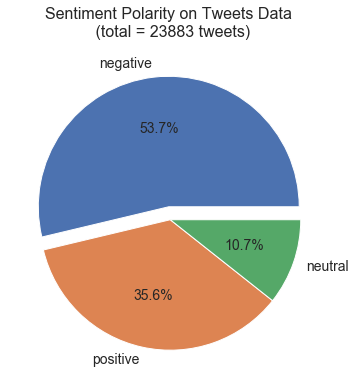

In [9]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in tweets['polarity'].value_counts()]
labels = list(tweets['polarity'].value_counts().index)
explode = (0.1, 0, 0)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', explode = explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Tweets Data \n (total = 23883 tweets)', fontsize = 16, pad = 20)
plt.show()

## Top 10 Positive and Negative Tweet Sentiments

In [10]:
pd.set_option('display.max_colwidth', 3000)
positive_tweets = tweets[tweets['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_clean', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=False).reset_index(drop = True)
positive_tweets.index += 1
positive_tweets[0:10]

,text_clean,polarity_score,polarity
1,good morning semangat yang kerja hari ini semoga dikasih rezeki yang berkah yang sekolahkuliah online hari ini semangat ya semoga ilmunya tetap jalan dan berkah ❤,29,positive
2,alhamdulillah seminggu ini padat kegiatan nya seharian kalau nggak bimbing judul kuliah online bahas penelitian ke lapangan dan minggu depan masih harus jadi moderator alhamdulillah ya allah hamba masih di beri kesempatan menikmati nikmatnya lelah bekerja 😊 masya allah😊,29,positive
3,good morning 🤗✨ thanks allah its friday 💕😇 yuk persiapan kuliah pagi 💪 semangat untuk kalian semua baik yang kuliah online wfh or wfo 🤗💪 jangan lupa mandi dan sarapan jaga kesehatan ya moots dari aku yang sudah mandi dan skinkeran wangi banget 😂,28,positive
4,selamat pagi dunia selamat pagi para mutual ku selamat pagi mahluk mahluk yang kucintai semangat kerja nya ya semangat kuliah online semangat beraktivitas dan jangan lupa untuk pake masker bawa pembersih tangan nya biar jauh jauh ama virus and jangan lupa sarapan ok 😘,27,positive
5,bersyukur masih bisa kuliah bersyukur masih dapet fasilitas yg mumpuni buat support kuliah online bersyukur masih dikasih kesehatan fisik kalo kesehatan mental mah jangan ditanya xixixi,26,positive
6,akhirnya dapat kuota geratis ya buat kuliah semoga berkah buat kuliah online aku dan uts ku lancar thank you so much semoga selalu diberikan kesehatan kebahagiaan dan murah rejeki oleh tuhan aamiin ❤️,26,positive
7,happy weekend guys apa rencana kalian hari ini aku kuliah online sekalian disambi pergi donor darah krn sudah jadwalnya trus diajak ngopi sama kakak spupu yg besok ultah free coffee free lunch besok free lunch lagi alhamdulilahh rekening kosong perut kagak 🙏🙏🙏,25,positive
8,bismillah dulu hari lagi kulon lagi kita hahaha kulon semester ini santai dan nilai bagus niat nya baik pengen happy jalanin kuliah online terus dikasih rezeki sama allah de,25,positive
9,selamat pagi 💜 yang lagi menuju kantor yuk semangat yang kuliah online bangun yuk tuntaskan yang nganggur yuk bantu mama dirumah semangat jangan siasiakan senin kalian 🥰🤗,25,positive
10,hari ke harusnya lebih bersyukur karna di bulan terakhir aku yang paling deket sama mama kuliah online papa kerja emas kerja dirumah berdua cuma sama mama ngobrol sama mama ketawa ngakak sama mama berantem juga sama mama bantu bantu mama nyapu nyiram,25,positive


In [11]:
pd.set_option('display.max_colwidth', 3000)
negative_tweets = tweets[tweets['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_clean', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=True)[0:10].reset_index(drop = True)
negative_tweets.index += 1
negative_tweets[0:10]

,text_clean,polarity_score,polarity
1,kuliah online apa yg kau dapat boros kuota mata sakit makin rabun minus nambah sakit kepala sakit bahu sakit punggung pusing pusing pusing pusing tp gada yg nyantol di otak,-48,negative
2,enjoy gimana nder kuliah online yang kudapatkan boros kuota sakit mata sakit bahu sakit pinggang sakit kepala mual setiap ngeliat hplaptop pusing pusing pusing i dont even know what i dont know,-43,negative
3,eh corona please udahan yuk cape kuliah online cape begadang cape overthinking cape nugas seabrek cape rebahan cape ngurus rumah cape scroll tiktok cape pokoknya ya di jogja juga ga menjamin kebahagiaan si at least ada tempat pelarian😢,-43,negative
4,pusing gw anjing gakuat gw kuliah online anjing anjing anjing astaga benar astaga astaga ga ngerti apa rumah ga kondusif kuota kekures abis anjing emang ni astaga anjing,-38,negative
5,ambis boleh tapi pls lah jangan egois sampe tolol goblok bodoh yang merugikan orang lain gila apa lo minta uts semua matkul dibikin projet anjing bgt ambis ambis tai kuliah online udh capek pake bikin project ngotak kek babi,-38,negative
6,gila stress sendiri gaenak bgt mana dirumah gabisa ngeluh stress ke ortu karena gamau mereka kepikiran mau ketemu temen tp corona mau nangis takut ditanyain knp bengkak benerbener mau gila gue kuliah online totalitas bgt stressnya,-37,negative
7,hp lama kameraku skrg buram terpaksa pake efek apps itupun memorinya ga tahan beban blm lgi nahan beban memori utk kuliah online ga tega liatnya😭 terpaksa mengurangi beban berat dimemoriku skrg pengen bgt upgrade hp realme now,-36,negative
8,yaallah maklum hamba di cari terus gara kudet ketinggalan ini itu di kuliah online soalnya hamba gak buka grup selain grup tugas yaallah gara isi grup satunya cem macem jadi pusing sendiri🥺😭,-35,negative
9,nih ya lu dpr gue enek bgt semester jd tololjenuh gara kuliah online eh lu tiba mancing amarah dan nyebabin org demo ngebentuk kerumunan trs guna gue bln mendek drmh apaan setan semua gara ketololan lu ngesahin gituan trs skrng fasum rusak jg salah lu,-35,negative
10,tiap hari cuman bangun tidur kuliah online ngerjain tugas tidur lagi gitu aja terus sampe jerapah lehernya pendek bosen juga kalo kaya gini terus lama lama bisa stres nih gue gara gara mikirin tujuan hidup yang ngga jelas kaya gini kehidupan seanjing itu emang ya,-34,negative


## Word Cloud

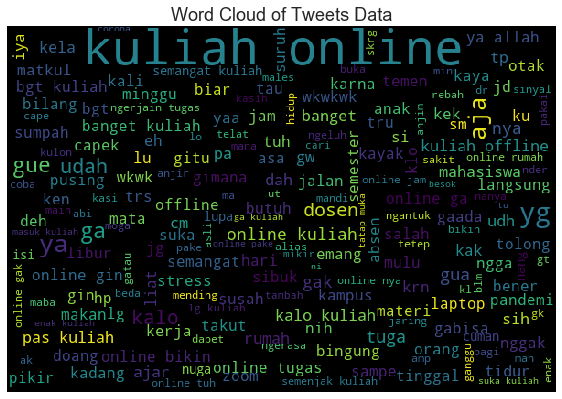

In [12]:
# Visualize word cloud

list_words=''
for tweet in tweets['text_preprocessed']:
    for word in tweet:
        list_words += ' '+(word)
        
wordcloud = WordCloud(width = 600, height = 400, background_color = 'black', min_font_size = 10).generate(list_words)
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

## Positive and Negative Word Cloud

In [13]:
# Function to group all positive/negative words
def words_with_sentiment(text):
    positive_words=[]
    negative_words=[]
    for word in text:
        score_pos = 0
        score_neg = 0
        if (word in lexicon_positive):
            score_pos = lexicon_positive[word]
        if (word in lexicon_negative):
            score_neg = lexicon_negative[word]
        
        if (score_pos + score_neg > 0):
            positive_words.append(word)
        elif (score_pos + score_neg < 0):
            negative_words.append(word)
            
    return positive_words, negative_words

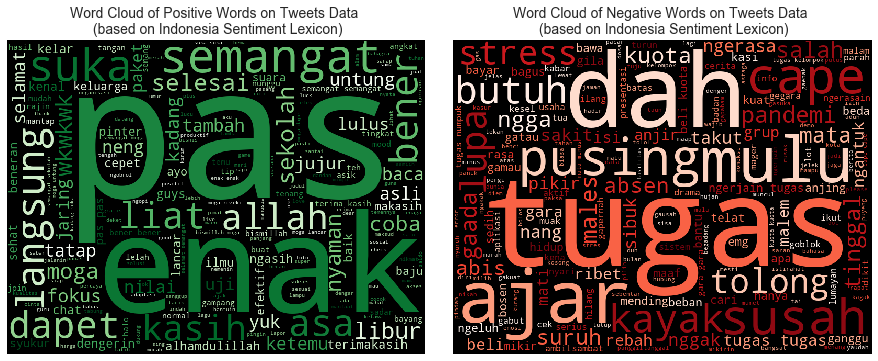

In [14]:
# Visualize positive and negative word cloud

sentiment_words = tweets['text_preprocessed'].apply(words_with_sentiment)
sentiment_words = list(zip(*sentiment_words))
positive_words = sentiment_words[0]
negative_words = sentiment_words[1]

fig, ax = plt.subplots(1, 2,figsize = (12, 10))
list_words_postive=''
for row_word in positive_words:
    for word in row_word:
        list_words_postive += ' '+(word)
wordcloud_positive = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Greens'
                               , min_font_size = 10).generate(list_words_postive)
ax[0].set_title('Word Cloud of Positive Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis('off')

list_words_negative=''
for row_word in negative_words:
    for word in row_word:
        list_words_negative += ' '+(word)
wordcloud_negative = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Reds'
                               , min_font_size = 10).generate(list_words_negative)
ax[1].set_title('Word Cloud of Negative Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis('off')

plt.show()

## Counts of Tweets Created based on Hours

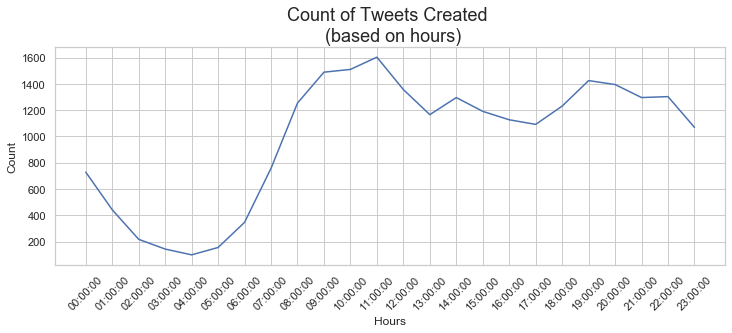

In [15]:
# Visualize counts of tweets created based on hours

tweets_created = pd.DataFrame()
tweets_created['created_at'] = tweets['created_at'].str.split(' ', expand = True)[1]
tweets_created['created_at'] = pd.to_datetime(tweets_created['created_at'])
tweets_created['created_at']= tweets_created['created_at'].dt.round('H')
tweets_created['created_at'] = tweets_created['created_at'].dt.time
tweets_created

fig, ax = plt.subplots(figsize = (12, 4))
x_values = tweets_created['created_at'].value_counts().sort_index().index
y_values = tweets_created['created_at'].value_counts().sort_index()
sns.lineplot(ax = ax, data = tweets, x = x_values, y = y_values)
ax.set_title('Count of Tweets Created \n (based on hours)', fontsize = 18)
ax.set_xlabel('Hours')
ax.set_xticks(x_values)
ax.set_xticklabels(x_values, rotation = 45)
ax.set_ylabel('Count')
plt.show()

# Sentiment Analysis Using LSTM

## Preprocessing Text Data

In [16]:
# Make text preprocessed (tokenized) to untokenized with toSentence Function
X = tweets['text_preprocessed'].apply(toSentence) 
max_features = 5000

# Tokenize text with specific maximum number of words to keep, based on word frequency
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)
X.shape

(23699, 48)

In [17]:
# Encode target data into numerical values
polarity_encode = {'negative' : 0, 'neutral' : 1, 'positive' : 2}
y = tweets['polarity'].map(polarity_encode).values

# Split the data (with composition data train 80%, data test 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(18959, 48) (18959,)
(4740, 48) (4740,)


## Model LSTM

In [18]:
# Create model function with default hyperparameter values

def create_model(embed_dim = 16, hidden_unit = 16, dropout_rate = 0.2, optimizers = Adam, learning_rate = 0.001):
    model = Sequential()
    model.add(Embedding(input_dim = max_features, output_dim = embed_dim, input_length = X_train.shape[1]))
    model.add(LSTM(units = hidden_unit, activation = 'tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 3, activation = 'softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers(lr = learning_rate), metrics = ['accuracy'])
    print(model.summary())
    return model

In [19]:
# # Hyperparameter tuning (to know the best hyperparameter for this model)

# # Wrapper model with default hyperparameter values
# model = KerasClassifier(build_fn = create_model, epochs = 25, batch_size=128) 

# # Hyperparameters
# embed_dim = [32, 64]
# hidden_unit = [16, 32, 64]
# dropout_rate = [0.2]
# optimizers = [Adam, RMSprop]
# learning_rate = [0.01, 0.001, 0.0001]
# epochs = [10, 25, 50, 100]
# batch_size = [128, 256]
# param_grid = dict(embed_dim = embed_dim, hidden_unit = hidden_unit, dropout_rate = dropout_rate,
#                   learning_rate = learning_rate, optimizers = optimizers, epochs = epochs, batch_size = batch_size)

# # Evaluation model with GridSearchCV to know what the best hyperparameter for model 
# grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3)
# grid_result = grid.fit(X_train, y_train)

# results = pd.DataFrame()
# results['means'] = grid_result.cv_results_['mean_test_score']
# results['stds'] = grid_result.cv_results_['std_test_score']
# results['params'] = grid_result.cv_results_['params']
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# results.to_csv(r'gridsearchcv_results.csv.csv', index = False, header = True)
# results.sort_values(by='means', ascending = False).reset_index(drop=True)

In [20]:
# Results from hyperparameter tuning
results = pd.read_csv('data/gridsearchcv_results.csv')
results.sort_values(by='means', ascending = False).reset_index(drop=True)

,means,stds,params
0,0.916513,0.002494,"{'batch_size': 128, 'dropout_rate': 0.2, 'embed_dim': 32, 'epochs': 10, 'hidden_unit': 16, 'learning_rate': 0.001, 'optimizers': <class 'keras.optimizers.RMSprop'>}"
1,0.916210,0.012881,"{'batch_size': 128, 'dropout_rate': 0.2, 'embed_dim': 64, 'epochs': 10, 'hidden_unit': 16, 'learning_rate': 0.001, 'optimizers': <class 'keras.optimizers.RMSprop'>}"
2,0.915358,0.012066,"{'batch_size': 128, 'dropout_rate': 0.2, 'embed_dim': 64, 'epochs': 10, 'hidden_unit': 32, 'learning_rate': 0.001, 'optimizers': <class 'keras.optimizers.RMSprop'>}"
3,0.915012,0.003830,"{'batch_size': 128, 'dropout_rate': 0.2, 'embed_dim': 32, 'epochs': 10, 'hidden_unit': 32, 'learning_rate': 0.001, 'optimizers': <class 'keras.optimizers.Adam'>}"
4,0.912172,0.008714,"{'batch_size': 128, 'dropout_rate': 0.2, 'embed_dim': 64, 'epochs': 10, 'hidden_unit': 16, 'learning_rate': 0.001, 'optimizers': <class 'keras.optimizers.Adam'>}"
...,...,...,...
283,0.651693,0.007537,"{'batch_size': 256, 'dropout_rate': 0.2, 'embed_dim': 32, 'epochs': 50, 'hidden_unit': 64, 'learning_rate': 0.0001, 'optimizers': <class 'keras.optimizers.Adam'>}"
284,0.651693,0.007537,"{'batch_size': 256, 'dropout_rate': 0.2, 'embed_dim': 32, 'epochs': 50, 'hidden_unit': 64, 'learning_rate': 0.0001, 'optimizers': <class 'keras.optimizers.RMSprop'>}"
285,0.651693,0.007537,"{'batch_size': 256, 'dropout_rate': 0.2, 'embed_dim': 64, 'epochs': 25, 'hidden_unit': 64, 'learning_rate': 0.0001, 'optimizers': <class 'keras.optimizers.Adam'>}"
286,0.651693,0.007537,"{'batch_size': 256, 'dropout_rate': 0.2, 'embed_dim': 64, 'epochs': 25, 'hidden_unit': 64, 'learning_rate': 0.0001, 'optimizers': <class 'keras.optimizers.RMSprop'>}"


In [21]:
# From results above, we know the best hyperparameter for this model is :
# {'batch_size': 128, 'dropout_rate': 0.2, 'embed_dim': 32, 'epochs': 10, 'hidden_unit': 16, 'learning_rate': 0.001, 'optimizers': <class 'keras.optimizers.RMSprop'>}

# Create the model with the best hyperparameter which has been determined
model = KerasClassifier(build_fn = create_model,
                        # Model Parameters
                        dropout_rate = 0.2,
                        embed_dim = 32,
                        hidden_unit = 16,
                        optimizers = RMSprop,
                        learning_rate = 0.001,
                   
                        # Fit Parameters
                        epochs=10, 
                        batch_size=128,
                        # Initiate validation data, which is 10% data from data train. It's used for evaluation model
                        validation_split = 0.1)
                         

model_prediction = model.fit(X_train, y_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 32)            160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 163,187
Trainable params: 163,187
Non-trainable params: 0
_________________________________________________________________
None


D:\application\Anaconda\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
D:\application\Anaconda\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 17063 samples, validate on 1896 samples
Epoch 1/10
17063/17063 [==============================] - 32s 2ms/step - loss: 0.8952 - accuracy: 0.5777 - val_loss: 0.7418 - val_accuracy: 0.7242
Epoch 2/10
17063/17063 [==============================] - 26s 2ms/step - loss: 0.5934 - accuracy: 0.7905 - val_loss: 0.5161 - val_accuracy: 0.8085
Epoch 3/10
17063/17063 [==============================] - 26s 2ms/step - loss: 0.4208 - accuracy: 0.8467 - val_loss: 0.4042 - val_accuracy: 0.8460
Epoch 4/10
17063/17063 [==============================] - 26s 2ms/step - loss: 0.3148 - accuracy: 0.8973 - val_loss: 0.3351 - val_accuracy: 0.8982
Epoch 5/10
17063/17063 [==============================] - 26s 2ms/step - loss: 0.2638 - accuracy: 0.9240 - val_loss: 0.3072 - val_accuracy: 0.9051
Epoch 6/10
17063/17063 [==============================] - 26s 2ms/step - loss: 0.2037 - accuracy: 0.9406 - val_loss: 0.2970 - val_accuracy: 0.9093
Epoch 7/10
17063/17063 [==============================] - 26s 2ms/ste

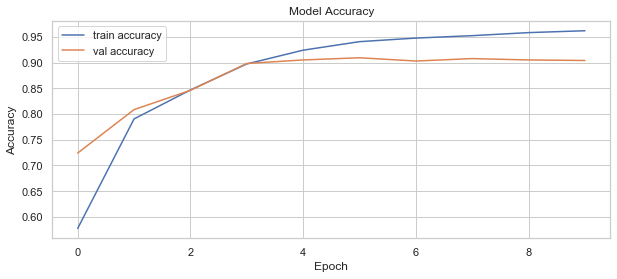

In [22]:
# Visualization model accuracy (train and val accuracy)

fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(model_prediction.history['accuracy'], label = 'train accuracy')
ax.plot(model_prediction.history['val_accuracy'], label = 'val accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc = 'upper left')
plt.show()

Model Accuracy on Test Data: 0.9105485232067511


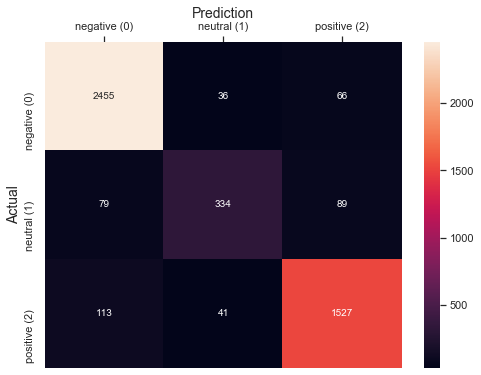

In [28]:
# Predict sentiment on data test by using model has been created, and then visualize a confusion matrix


y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Model Accuracy on Test Data:', accuracy)
confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(confusion_matrix(y_true = y_test, y_pred = y_pred), fmt = 'g', annot = True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize = 14)
ax.set_xticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
ax.set_ylabel('Actual', fontsize = 14)
ax.set_yticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
plt.show()

In [24]:
# Results from prediction sentiment on data test
text_clean = tweets['text_clean']
text_train, text_test = train_test_split(text_clean, test_size = 0.2, random_state = 0)
result_test = pd.DataFrame(data = zip(text_test, y_pred), columns = ['text', 'polarity'])
polarity_decode = {0 : 'Negative', 1 : 'Neutral', 2 : 'Positive'}
result_test['polarity'] = result_test['polarity'].map(polarity_decode)
pd.set_option('max_colwidth', 300)
result_test

,text,polarity
0,kepala otak kau kuliah online enak stress iya anjing fliss manusia itu butuh temen interaksi bukan hah heh hoh mulu kayak keong😭,Negative
1,kuliah online asik juga ya kalo udah terbiasa ga perlu bolak balik kampus yg penting internet lancar wkwkwkwkw,Positive
2,doain y moga ga ampe sakit jiwa gegara sistem kuliah online ngalor kidul gini😭💔,Negative
3,yes dibeliin laptop baru buat kuliah online sekalian juga bisa buat nge game hehehe,Positive
4,abis corona kelar aku mau kuliah online aja,Positive
...,...,...
4735,drakor an apa kuliah online,Neutral
4736,lgi kuliah online otak masih lemot sempatnya dikasih kuis setelah itu dikasih tugas lagi,Negative
4737,suka banget kalo kuliah online gini ga perlu capek pilih baju dandan dan pergi ke kampus cuma dirumah doang pokoknya seneng poll kalian gitu juga gak sih hehehehehe,Positive
4738,—kuliah online— le lagi makan le dosen silahkan kamera di aktifkan jika tidak kalian saya anggap tidak hadir le aku kesal banget pengen sumpah in 😩😩😩,Negative


## Predict with Other Data

In [25]:
# Initializing and preprocessing new text data
otherData = pd.DataFrame()
otherData['text'] = ['enaknya kuliah online,  ga perlu capek" ke kampus dan bisa santai dirumah',
                     'Tapi serius deh semakin kesini ngerasa kuliah online makin ga efektif, ga paham materi blasss, kopong, berasa yauda kek ga kuliah' 
                    ]

otherData['text_clean'] = otherData['text'].apply(cleaningText)
otherData['text_clean'] = otherData['text_clean'].apply(casefoldingText)
otherData.drop(['text'], axis = 1, inplace = True)

otherData['text_preprocessed'] = otherData['text_clean'].apply(tokenizingText)
otherData['text_preprocessed'] = otherData['text_preprocessed'].apply(filteringText)
otherData['text_preprocessed'] = otherData['text_preprocessed'].apply(stemmingText)
otherData

,text_clean,text_preprocessed
0,enaknya kuliah online ga perlu capek ke kampus dan bisa santai dirumah,"[enak, kuliah, online, ga, capek, kampus, santai, rumah]"
1,tapi serius deh semakin kesini ngerasa kuliah online makin ga efektif ga paham materi blasss kopong berasa yauda kek ga kuliah,"[serius, deh, kesini, ngerasa, kuliah, online, ga, efektif, ga, paham, materi, blasss, kopong, asa, yauda, kek, ga, kuliah]"


In [26]:
# Preprocessing text data

# Make text preprocessed (tokenized) to untokenized with toSentence Function
X_otherData = otherData['text_preprocessed'].apply(toSentence)
X_otherData = tokenizer.texts_to_sequences(X_otherData.values)
X_otherData = pad_sequences(X_otherData, maxlen = X.shape[1])
X_otherData

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   37,    1,    2,    3,
          53,   57,  541,   18],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,  324,  101,
         893,  147,    1,    2,    3,  294,    3,   95,   49, 3340,  114,
        2465,   61,    3,    1]])

In [27]:
# Results from prediction sentiment on text data

y_pred_otherData = model.predict(X_otherData)
otherData['Result Prediction'] = y_pred_otherData

polarity_decode = {0 : 'Negative', 1 : 'Neutral', 2 : 'Positive'}
otherData['Result Prediction'] = otherData['Result Prediction'].map(polarity_decode)
otherData

,text_clean,text_preprocessed,Result Prediction
0,enaknya kuliah online ga perlu capek ke kampus dan bisa santai dirumah,"[enak, kuliah, online, ga, capek, kampus, santai, rumah]",Positive
1,tapi serius deh semakin kesini ngerasa kuliah online makin ga efektif ga paham materi blasss kopong berasa yauda kek ga kuliah,"[serius, deh, kesini, ngerasa, kuliah, online, ga, efektif, ga, paham, materi, blasss, kopong, asa, yauda, kek, ga, kuliah]",Negative
